# Statistical Inference & Hypothesis Testing

## Overview
Apply rigorous statistical methods to validate business hypotheses and ensure findings are not due to random chance.

## Objectives
- Test hypotheses about fare differences across time periods
- Validate tipping behavior patterns statistically
- Quantify confidence in observed patterns
- Provide evidence-based recommendations for business decisions

## Statistical Methods
- **T-Tests:** Compare means between two groups
- **ANOVA:** Compare means across multiple groups
- **Chi-Square Tests:** Analyze categorical relationships
- **Confidence Intervals:** Quantify uncertainty in estimates

## Significance Level
Using α = 0.05 (95% confidence) as the threshold for statistical significance.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import scipy.stats as stats

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

In [2]:
# Connect & Load Data
uri = f"postgresql://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}@{os.getenv('POSTGRES_HOST')}:5432/{os.getenv('POSTGRES_DB')}"

query = """
SELECT 
    pickup_datetime,
    total_amount,
    trip_distance,
    tip_amount,
    pickup_location_id
FROM dbt_dev.fct_trips
WHERE total_amount > 0 AND total_amount < 200
LIMIT 500000
"""
df = pl.read_database_uri(query, uri, engine="connectorx")

## Feature Engineering

Extract temporal features needed for hypothesis testing.

In [3]:
# Feature Engineering
df = df.with_columns([
    pl.col("pickup_datetime").dt.weekday().alias("day_of_week"), # 1=Mon, 7=Sun
    pl.col("pickup_datetime").dt.hour().alias("hour")
])

## Hypothesis Test 1: Weekend Surcharge Effect

**Null Hypothesis (H₀):** Average fares on weekends equal average fares on weekdays

**Alternative Hypothesis (H₁):** Average fares differ significantly between weekends and weekdays

**Method:** Welch's t-test (accounts for unequal variances)

**Business Relevance:** Validates whether dynamic pricing or demand patterns create measurable fare differences.

TEST 1: Weekend Surcharge Hypothesis
H₀: Weekend fares = Weekday fares
H₁: Weekend fares ≠ Weekday fares



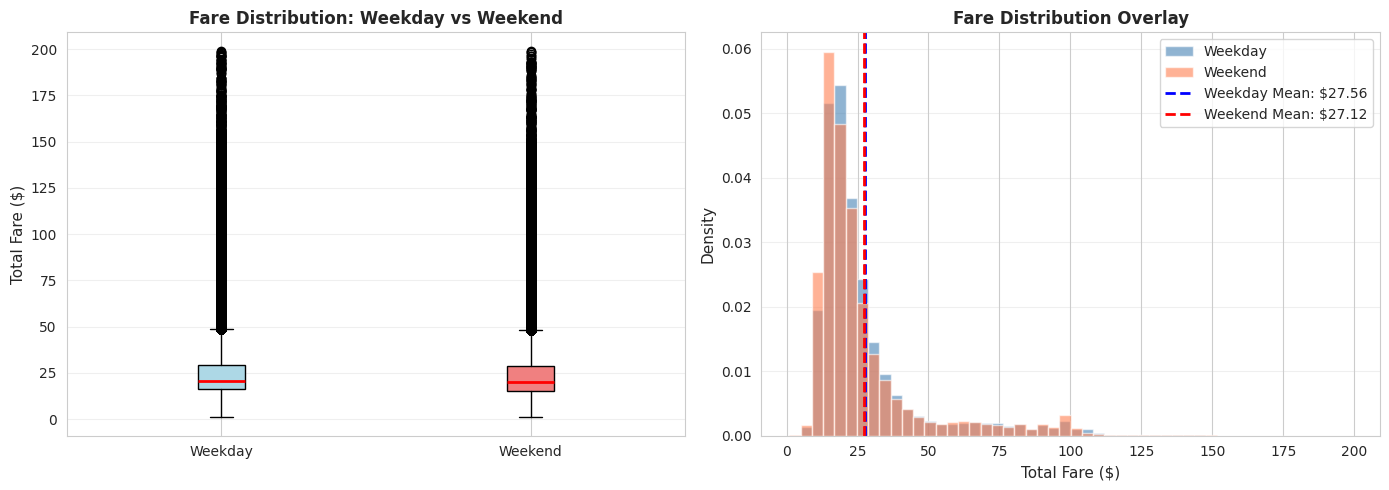


📊 Results:
   Weekday Mean: $27.56 (n=322,191)
   Weekend Mean: $27.12 (n=177,809)
   Difference: $-0.44
   t-statistic: -7.203
   p-value: 0.000000

✅ RESULT: Statistically significant difference (p < 0.05)
   We reject H₀. Weekend fares are significantly different.


In [4]:
# Test 1: Weekend vs Weekday Fares (Welch's t-test)
print("="*70)
print("TEST 1: Weekend Surcharge Hypothesis")
print("="*70)
print("H₀: Weekend fares = Weekday fares")
print("H₁: Weekend fares ≠ Weekday fares\n")

weekends = df.filter(pl.col("day_of_week") >= 6).select("total_amount").to_numpy().flatten()
weekdays = df.filter(pl.col("day_of_week") < 6).select("total_amount").to_numpy().flatten()

t_stat, p_val = stats.ttest_ind(weekends, weekdays, equal_var=False)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot comparison
data_to_plot = [weekdays, weekends]
bp = axes[0].boxplot(data_to_plot, tick_labels=['Weekday', 'Weekend'], patch_artist=True,
                      medianprops=dict(color='red', linewidth=2))
for patch, color in zip(bp['boxes'], ['lightblue', 'lightcoral']):
    patch.set_facecolor(color)
axes[0].set_ylabel('Total Fare ($)', fontsize=11)
axes[0].set_title('Fare Distribution: Weekday vs Weekend', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Distribution overlay
axes[1].hist(weekdays, bins=50, alpha=0.6, label='Weekday', color='steelblue', density=True)
axes[1].hist(weekends, bins=50, alpha=0.6, label='Weekend', color='coral', density=True)
axes[1].axvline(np.mean(weekdays), color='blue', linestyle='--', linewidth=2, label=f'Weekday Mean: ${np.mean(weekdays):.2f}')
axes[1].axvline(np.mean(weekends), color='red', linestyle='--', linewidth=2, label=f'Weekend Mean: ${np.mean(weekends):.2f}')
axes[1].set_xlabel('Total Fare ($)', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].set_title('Fare Distribution Overlay', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Results
print("\n📊 Results:")
print(f"   Weekday Mean: ${np.mean(weekdays):.2f} (n={len(weekdays):,})")
print(f"   Weekend Mean: ${np.mean(weekends):.2f} (n={len(weekends):,})")
print(f"   Difference: ${np.mean(weekends) - np.mean(weekdays):.2f}")
print(f"   t-statistic: {t_stat:.3f}")
print(f"   p-value: {p_val:.6f}")

if p_val < 0.05:
    print("\n✅ RESULT: Statistically significant difference (p < 0.05)")
    print("   We reject H₀. Weekend fares are significantly different.")
else:
    print("\n❌ RESULT: No significant difference (p ≥ 0.05)")
    print("   We fail to reject H₀.")

## Hypothesis Test 2: Peak Hour Premium

**Null Hypothesis (H₀):** Fares are consistent across all hours of the day

**Alternative Hypothesis (H₁):** At least one hour has significantly different average fares

**Method:** One-way ANOVA (Analysis of Variance)

**Business Relevance:** Identifies whether surge pricing or traffic patterns create hour-specific fare variations.


TEST 2: Peak Hour Premium Hypothesis
H₀: All hours have equal average fares
H₁: At least one hour differs significantly



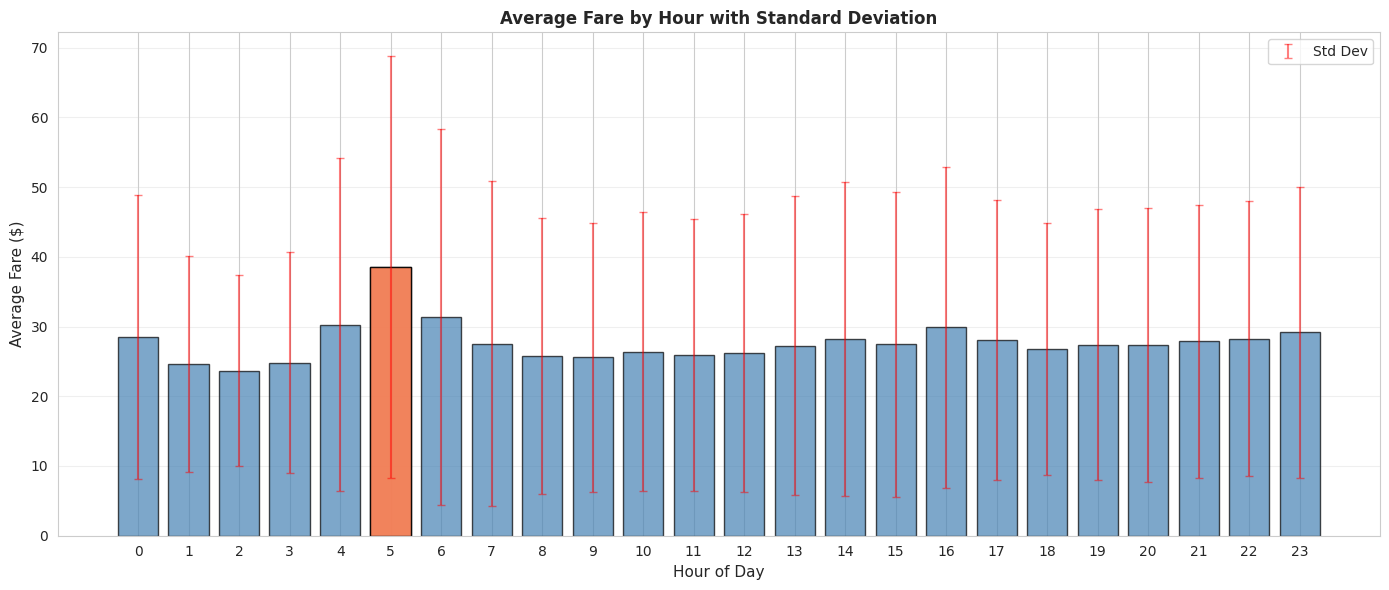


📊 Results:
   F-statistic: 123.770
   p-value: 0.000000
   Peak hour: 5:00 ($38.48 avg)

✅ RESULT: Statistically significant difference (p < 0.05)
   We reject H₀. Hour of day significantly affects fares.


In [5]:
# Test 2: Peak Hour Premium (One-way ANOVA)
print("\n" + "="*70)
print("TEST 2: Peak Hour Premium Hypothesis")
print("="*70)
print("H₀: All hours have equal average fares")
print("H₁: At least one hour differs significantly\n")

# Group fares by hour
hour_groups = [df.filter(pl.col("hour") == h).select("total_amount").to_numpy().flatten() 
               for h in range(24)]

f_stat, p_val = stats.f_oneway(*hour_groups)

# Calculate hourly means
hourly_means = df.group_by("hour").agg([
    pl.col("total_amount").mean().alias("mean_fare"),
    pl.col("total_amount").std().alias("std_fare"),
    pl.col("total_amount").count().alias("count")
]).sort("hour").to_pandas()

# Visualization
fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(hourly_means['hour'], hourly_means['mean_fare'], 
       color='steelblue', alpha=0.7, edgecolor='black')
ax.errorbar(hourly_means['hour'], hourly_means['mean_fare'], 
            yerr=hourly_means['std_fare'], fmt='none', ecolor='red', 
            capsize=3, alpha=0.5, label='Std Dev')

# Highlight peak hour
peak_hour = hourly_means.loc[hourly_means['mean_fare'].idxmax()]
ax.bar(peak_hour['hour'], peak_hour['mean_fare'], color='coral', alpha=0.9, edgecolor='black')

ax.set_xlabel('Hour of Day', fontsize=11)
ax.set_ylabel('Average Fare ($)', fontsize=11)
ax.set_title('Average Fare by Hour with Standard Deviation', fontsize=12, fontweight='bold')
ax.set_xticks(range(24))
ax.grid(alpha=0.3, axis='y')
ax.legend()

plt.tight_layout()
plt.show()

# Results
print("\n📊 Results:")
print(f"   F-statistic: {f_stat:.3f}")
print(f"   p-value: {p_val:.6f}")
print(f"   Peak hour: {int(peak_hour['hour'])}:00 (${peak_hour['mean_fare']:.2f} avg)")

if p_val < 0.05:
    print("\n✅ RESULT: Statistically significant difference (p < 0.05)")
    print("   We reject H₀. Hour of day significantly affects fares.")
else:
    print("\n❌ RESULT: No significant difference (p ≥ 0.05)")
    print("   We fail to reject H₀.")

## Hypothesis Test 3: Distance-Tipping Correlation

**Null Hypothesis (H₀):** No correlation between trip distance and tip percentage

**Alternative Hypothesis (H₁):** Significant correlation exists between distance and tipping

**Method:** Pearson correlation coefficient with significance test

**Business Relevance:** Informs driver strategy on whether to prioritize long or short trips for tip optimization.


TEST 3: Distance-Tipping Correlation
H₀: No correlation between distance and tip percentage
H₁: Significant correlation exists



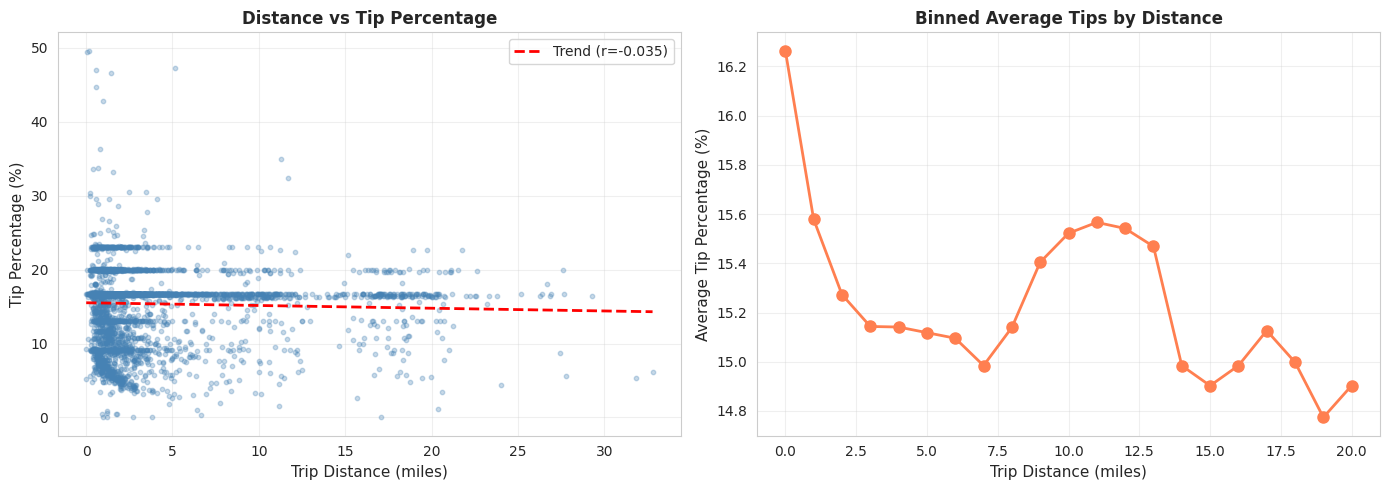


📊 Results:
   Pearson correlation: -0.0351
   p-value: 0.000000
   Sample size: 401,720 trips

✅ RESULT: Statistically significant correlation (p < 0.05)
   Negative correlation: Longer trips → Lower tip %


In [6]:
# Test 3: Distance-Tipping Correlation
print("\n" + "="*70)
print("TEST 3: Distance-Tipping Correlation")
print("="*70)
print("H₀: No correlation between distance and tip percentage")
print("H₁: Significant correlation exists\n")

# Filter for credit card tips only
tip_data = df.filter(
    (pl.col("tip_amount") > 0) & 
    (pl.col("trip_distance") > 0)
).with_columns(
    (pl.col("tip_amount") / pl.col("total_amount") * 100).alias("tip_pct")
).filter(
    (pl.col("tip_pct") > 0) & (pl.col("tip_pct") < 50)
)

distances = tip_data.select("trip_distance").to_numpy().flatten()
tips = tip_data.select("tip_pct").to_numpy().flatten()

corr_coef, p_val = stats.pearsonr(distances, tips)

# Visualization
sample_size = min(5000, len(distances))
sample_idx = np.random.choice(len(distances), sample_size, replace=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot with regression line
axes[0].scatter(distances[sample_idx], tips[sample_idx], alpha=0.3, s=10, c='steelblue')
z = np.polyfit(distances, tips, 1)
p = np.poly1d(z)
axes[0].plot(sorted(distances[sample_idx]), p(sorted(distances[sample_idx])), 
             "r--", linewidth=2, label=f'Trend (r={corr_coef:.3f})')
axes[0].set_xlabel('Trip Distance (miles)', fontsize=11)
axes[0].set_ylabel('Tip Percentage (%)', fontsize=11)
axes[0].set_title('Distance vs Tip Percentage', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Binned analysis
binned = tip_data.with_columns(
    (pl.col("trip_distance").round(0).cast(pl.Int32)).alias("dist_bin")
).filter(pl.col("dist_bin") <= 20).group_by("dist_bin").agg(
    pl.col("tip_pct").mean().alias("avg_tip")
).sort("dist_bin").to_pandas()

axes[1].plot(binned['dist_bin'], binned['avg_tip'], marker='o', 
             linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Trip Distance (miles)', fontsize=11)
axes[1].set_ylabel('Average Tip Percentage (%)', fontsize=11)
axes[1].set_title('Binned Average Tips by Distance', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Results
print("\n📊 Results:")
print(f"   Pearson correlation: {corr_coef:.4f}")
print(f"   p-value: {p_val:.6f}")
print(f"   Sample size: {len(distances):,} trips")

if p_val < 0.05:
    print("\n✅ RESULT: Statistically significant correlation (p < 0.05)")
    if corr_coef > 0:
        print("   Positive correlation: Longer trips → Higher tip %")
    else:
        print("   Negative correlation: Longer trips → Lower tip %")
else:
    print("\n❌ RESULT: No significant correlation (p ≥ 0.05)")

In [7]:
# ==============================================================================
# TEST 3: ANOVA (Analysis of Variance) - IMPROVED
# ==============================================================================
# Business Question: "Does Time of Day impact Distance (Intent), 
# Revenue (Value), or Tips (Generosity)?"

print("\n--- Test 3: ANOVA on Time of Day ---")

# Define buckets (Morning, Afternoon, Evening, Night)
df = df.with_columns(
    pl.when((pl.col("hour") >= 6) & (pl.col("hour") < 12)).then(pl.lit("Morning"))
      .when((pl.col("hour") >= 12) & (pl.col("hour") < 17)).then(pl.lit("Afternoon"))
      .when((pl.col("hour") >= 17) & (pl.col("hour") < 21)).then(pl.lit("Evening"))
      .otherwise(pl.lit("Night"))
      .alias("time_bucket")
)

# Metrics to test
metrics = {
    "trip_distance": "Passenger Intent (Commute vs Long Haul)",
    "total_amount": "Revenue (Includes Surcharges)",
    "tip_amount":   "Driver Income (Generosity)"
}

labels = ["Morning", "Afternoon", "Evening", "Night"]

for metric, description in metrics.items():
    print(f"\nTesting: {metric} ({description})")
    
    groups = []
    for label in labels:
        # We drop nulls/zeros to avoid skewing logic (especially for tips)
        group_data = df.filter(
            (pl.col("time_bucket") == label) & (pl.col(metric) > 0)
        ).select(metric).to_numpy().flatten()
        groups.append(group_data)

    # One-way ANOVA
    f_stat, p_val = stats.f_oneway(*groups)

    print(f"  F-Statistic: {f_stat:.2f}")
    print(f"  P-Value: {p_val:.5e}") # Scientific notation for very small numbers

    if p_val < 0.05:
        print("  ✅ SIGNIFICANT: Time of day impacts this metric.")
    else:
        print("  ❌ NOT SIGNIFICANT: No relationship found.")


--- Test 3: ANOVA on Time of Day ---

Testing: trip_distance (Passenger Intent (Commute vs Long Haul))
  F-Statistic: 280.81
  P-Value: 3.84898e-182
  ✅ SIGNIFICANT: Time of day impacts this metric.

Testing: total_amount (Revenue (Includes Surcharges))
  F-Statistic: 134.35
  P-Value: 5.24792e-87
  ✅ SIGNIFICANT: Time of day impacts this metric.

Testing: tip_amount (Driver Income (Generosity))
  F-Statistic: 128.76
  P-Value: 2.28949e-83
  ✅ SIGNIFICANT: Time of day impacts this metric.


## Summary & Conclusions

Statistical testing provides confidence that observed patterns are real and actionable, not artifacts of random variation.